Kaggle score: 0.97449

In [1]:
# ВНИМАНИЕ; версия Pillow установвленна по умолчанию - '7.0.0'
# Эта версия ломает torchvision
import PIL
PIL.__version__

'7.0.0'

In [2]:
!pip uninstall -y Pillow
!pip install -Iv Pillow==5.3.0

Uninstalling Pillow-7.0.0:
  Successfully uninstalled Pillow-7.0.0
Created temporary directory: /tmp/pip-ephem-wheel-cache-2el_ck7r
Created temporary directory: /tmp/pip-req-tracker-s5hinfz1
Created requirements tracker '/tmp/pip-req-tracker-s5hinfz1'
Created temporary directory: /tmp/pip-install-9ln0juwv
1 location(s) to search for versions of Pillow:
* https://pypi.org/simple/pillow/
Getting page https://pypi.org/simple/pillow/
Found index url https://pypi.org/simple
Looking up "https://pypi.org/simple/pillow/" in the cache
Request header has "max_age" as 0, cache bypassed
Starting new HTTPS connection (1): pypi.org:443
https://pypi.org:443 "GET /simple/pillow/ HTTP/1.1" 200 168421
Updating cache with response from "https://pypi.org/simple/pillow/"
Caching due to etag
Analyzing links from page https://pypi.org/simple/pillow/
  Found link https://files.pythonhosted.org/packages/72/e6/692512c5d9dc97f83a91f8a75806e0b9e910ebd8d6b0b3d6ca9a249c1e26/Pillow-1.0.tar.gz#sha256=be8643522995b496

---


**ВНИМАНИЕ: На этом этапе обязательно перезагрузить рантайм (Runtime -> Restart Runtime). Иначе версия 5.3.0 не будет загружена в рантайм.**

После перезапуска рантайма следует продолжить исполнять ячейки далее.

---



## **Физтех-Школа Прикладной математики и информатики (ФПМИ) МФТИ**

# Путешествие по Спрингфилду.


Сегодня вам предстоить помочь телекомпании FOX  в обработке их контента. Как вы знаете сериал Симсоны идет на телеэкранах более 25 лет и за это время скопилось очень много видео материала. Персоонажи менялись вместе с изменяющимися графическими технологиями   и Гомер 2018 не очень похож на Гомера 1989. Нашей задачей будет научиться классифицировать персонажей проживающих в Спрингфилде. Думаю, что нет смысла представлять каждого из них в отдельности.



 ![alt text](https://vignette.wikia.nocookie.net/simpsons/images/5/5a/Spider_fat_piglet.png/revision/latest/scale-to-width-down/640?cb=20111118140828)



### Установка зависимостей

In [1]:
!pip install -U torch torchvision

Requirement already up-to-date: torch in /usr/local/lib/python3.6/dist-packages (1.5.0+cu101)
Requirement already up-to-date: torchvision in /usr/local/lib/python3.6/dist-packages (0.6.0+cu101)


In [0]:
# Вручную ищем и устанавливаем подходящуюю версию 
# https://download.pytorch.org/whl/torch_stable.html 
!pip install -q 'https://download.pytorch.org/whl/cu101/torch-1.5.0%2Bcu101-cp36-cp36m-linux_x86_64.whl' torchvision
import torch

In [3]:
# we will verify that GPU is enabled for this notebook
# following should print: CUDA is available!  Training on GPU ...
# 
# if it prints otherwise, then you need to enable GPU: 
# from Menu > Runtime > Change Runtime Type > Hardware Accelerator > GPU

import torch
import numpy as np

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [4]:
from google.colab import drive
drive.mount('/content/gdrive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive/




---

**ВНИМАНИЕ: скачайте датасет с каггла и положите его в корень своего гугл диска!**

---



In [0]:
!unzip -q /content/gdrive/My\ Drive/journey-springfield.zip

In [6]:
!ls train

simpsons_dataset


In [7]:
!nvidia-smi
import torch
torch.cuda.is_available()

Sat May 23 13:03:48 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   54C    P8    10W /  70W |     10MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

True

В нашем тесте будет 990 картнок, для которых вам будет необходимо предсказать класс.

In [0]:
import pickle
import numpy as np
from skimage import io

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision import transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F 

#Воспроизводимость нотбука
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

from matplotlib import colors, pyplot as plt
%matplotlib inline

# в sklearn не все гладко, чтобы в colab удобно выводить картинки 
# мы будем игнорировать warnings
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)


In [0]:
# разные режимы датасета 
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224
# работаем на видеокарте
DEVICE = torch.device("cuda")

https://jhui.github.io/2018/02/09/PyTorch-Data-loading-preprocess_torchvision/


Ниже мы исспользуем враппер над датасетом для удобной работы. Вам стоит понимать, что происходит с LabelEncoder и  с torch.Transformation. 

ToTensor конвертирует  PIL Image с параметрами в диапазоне [0, 255] (как все пиксели) в FloatTensor размера (C x H x W) [0,1] , затем производится масштабирование:
$input = \frac{input - \mu}{\text{standard deviation}} \\$,      константы - средние и дисперсии по каналам на основе ImageNet


Стоит также отметить, что мы переопределяем метод __getitem__ для удобства работы с данной структурой данных.
 Также используется LabelEncoder для преобразования строковых меток классов в id и обратно. В описании датасета указано, что картинки разного размера, так как брались напрямую с видео, поэтому следуем привести их к одному размер (это делает метод  _prepare_sample) 

In [0]:
class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)
     
        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
  
    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
        ])
        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        x = np.array(x / 255, dtype='float32')
        x = transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y
        
    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

In [0]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [0]:
TRAIN_DIR = Path('train/simpsons_dataset')
TEST_DIR = Path('testset/testset')

train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [0]:
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels)

In [0]:
val_dataset = SimpsonsDataset(val_files, mode='val')

Давайте посмотрим на наших героев внутри датасета.

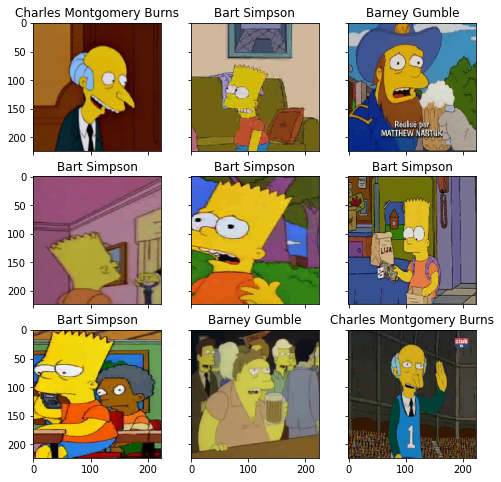

In [15]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

Можете добавить ваши любимые сцены и классифицировать их. (веселые результаты можно кидать в чат)

### Построение нейросети




In [0]:
class ModelCnn(nn.Module):
  
    def __init__(self, n_classes):
        
        super().__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=7, stride=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, stride=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1,
                                                                    padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, 
                                                                    padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, 
                                                                     padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )
        
        self.fc1 = nn.Sequential(
            nn.Linear(6 * 6 * 128, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
        )
        self.fc2 = nn.Sequential(
            nn.Linear(1024, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU()
        )
        
        self.fc3 = nn.Sequential(
            nn.Linear(1024, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU()
        )
        
        self.fc4 = nn.Sequential(
            nn.Linear(1024, n_classes)
        )  

  
    def forward(self, x):
        
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        

        x = F.interpolate(x, size=(6, 6), mode='bilinear')  
        x = x.view(x.size(0), 6 * 6 * 128)
    
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        
        x = self.fc4(x)
        
        return x

In [0]:
def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
  
    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
              
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [0]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

In [0]:
def train(train_files, val_files, model, epochs, batch_size):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        #Поменялся optimizer 
        opt = torch.optim.AdamW(model.parameters(), amsgrad = True)
        criterion = nn.CrossEntropyLoss()
        #Добавлен sheduler
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt,'min')

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            print("loss", train_loss)
            
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            scheduler.step(val_loss)
            history.append((train_loss, train_acc, val_loss, val_acc))
            
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            
    return history

In [0]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [21]:
n_classes = len(np.unique(train_val_labels))
model_cnn = ModelCnn(n_classes).to(DEVICE)
print("we will classify :{}".format(n_classes))
print(model_cnn)

we will classify :42
ModelCnn(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(7, 7), stride=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(5, 5), stride=(2, 2))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (conv4): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (conv5): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), paddin

Запустим обучение сети.

In [0]:
if val_dataset is None:
    val_dataset = SimpsonsDataset(val_files, mode='val')
    
train_dataset = SimpsonsDataset(train_files, mode='train')

In [23]:
history = train(train_dataset, val_dataset, model=model_cnn, epochs=20, batch_size=32)

epoch:   0%|          | 0/20 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2973: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


loss 1.8217102857568217


epoch:   5%|▌         | 1/20 [02:49<53:44, 169.70s/it]


Epoch 001 train_loss: 1.8217     val_loss 1.4332 train_acc 0.4998 val_acc 0.6011
loss 1.1897067080425512


epoch:  10%|█         | 2/20 [05:38<50:50, 169.46s/it]


Epoch 002 train_loss: 1.1897     val_loss 0.9229 train_acc 0.6682 val_acc 0.7511
loss 0.8062168538695695


epoch:  15%|█▌        | 3/20 [08:27<47:58, 169.33s/it]


Epoch 003 train_loss: 0.8062     val_loss 0.7635 train_acc 0.7704 val_acc 0.7862
loss 0.6180618725936803


epoch:  20%|██        | 4/20 [11:15<45:03, 168.99s/it]


Epoch 004 train_loss: 0.6181     val_loss 0.7108 train_acc 0.8220 val_acc 0.8078
loss 0.48174099852339586


epoch:  25%|██▌       | 5/20 [14:04<42:12, 168.83s/it]


Epoch 005 train_loss: 0.4817     val_loss 0.6258 train_acc 0.8587 val_acc 0.8338
loss 0.3551013986846734


epoch:  30%|███       | 6/20 [16:51<39:16, 168.33s/it]


Epoch 006 train_loss: 0.3551     val_loss 0.5691 train_acc 0.8979 val_acc 0.8525
loss 0.2855064968402148


epoch:  35%|███▌      | 7/20 [19:39<36:27, 168.30s/it]


Epoch 007 train_loss: 0.2855     val_loss 0.5679 train_acc 0.9154 val_acc 0.8609
loss 0.21715613973638845


epoch:  40%|████      | 8/20 [22:30<33:47, 168.93s/it]


Epoch 008 train_loss: 0.2172     val_loss 0.5692 train_acc 0.9349 val_acc 0.8642
loss 0.19115867398674985


epoch:  45%|████▌     | 9/20 [25:18<30:57, 168.90s/it]


Epoch 009 train_loss: 0.1912     val_loss 0.5388 train_acc 0.9432 val_acc 0.8749
loss 0.14064065181940966


epoch:  50%|█████     | 10/20 [28:08<28:09, 168.99s/it]


Epoch 010 train_loss: 0.1406     val_loss 0.6354 train_acc 0.9600 val_acc 0.8586
loss 0.13249535947664123


epoch:  55%|█████▌    | 11/20 [30:56<25:20, 168.96s/it]


Epoch 011 train_loss: 0.1325     val_loss 0.5607 train_acc 0.9625 val_acc 0.8745
loss 0.0843273674002217


epoch:  60%|██████    | 12/20 [33:45<22:31, 168.88s/it]


Epoch 012 train_loss: 0.0843     val_loss 0.5902 train_acc 0.9760 val_acc 0.8823
loss 0.07964139083698529


epoch:  65%|██████▌   | 13/20 [36:34<19:41, 168.77s/it]


Epoch 013 train_loss: 0.0796     val_loss 0.6370 train_acc 0.9771 val_acc 0.8791
loss 0.07906222750452781


epoch:  70%|███████   | 14/20 [39:22<16:51, 168.59s/it]


Epoch 014 train_loss: 0.0791     val_loss 0.5430 train_acc 0.9773 val_acc 0.8921
loss 0.0593957474021255


epoch:  75%|███████▌  | 15/20 [42:10<14:02, 168.47s/it]


Epoch 015 train_loss: 0.0594     val_loss 0.5760 train_acc 0.9823 val_acc 0.8857
loss 0.05071916314688725


epoch:  80%|████████  | 16/20 [44:58<11:13, 168.31s/it]


Epoch 016 train_loss: 0.0507     val_loss 0.6572 train_acc 0.9850 val_acc 0.8791
loss 0.053948857813292984


epoch:  85%|████████▌ | 17/20 [47:45<08:23, 167.99s/it]


Epoch 017 train_loss: 0.0539     val_loss 0.5374 train_acc 0.9850 val_acc 0.9001
loss 0.018378392656363585


epoch:  90%|█████████ | 18/20 [50:33<05:35, 167.92s/it]


Epoch 018 train_loss: 0.0184     val_loss 0.5687 train_acc 0.9950 val_acc 0.8949
loss 0.003261855152956967


epoch:  95%|█████████▌| 19/20 [53:20<02:47, 167.54s/it]


Epoch 019 train_loss: 0.0033     val_loss 0.5570 train_acc 0.9989 val_acc 0.9043
loss 0.0011941931932477614


epoch: 100%|██████████| 20/20 [56:06<00:00, 168.32s/it]


Epoch 020 train_loss: 0.0012     val_loss 0.5719 train_acc 0.9996 val_acc 0.9043


Построим кривые обучения

In [0]:
loss, acc, val_loss, val_acc = zip(*history)

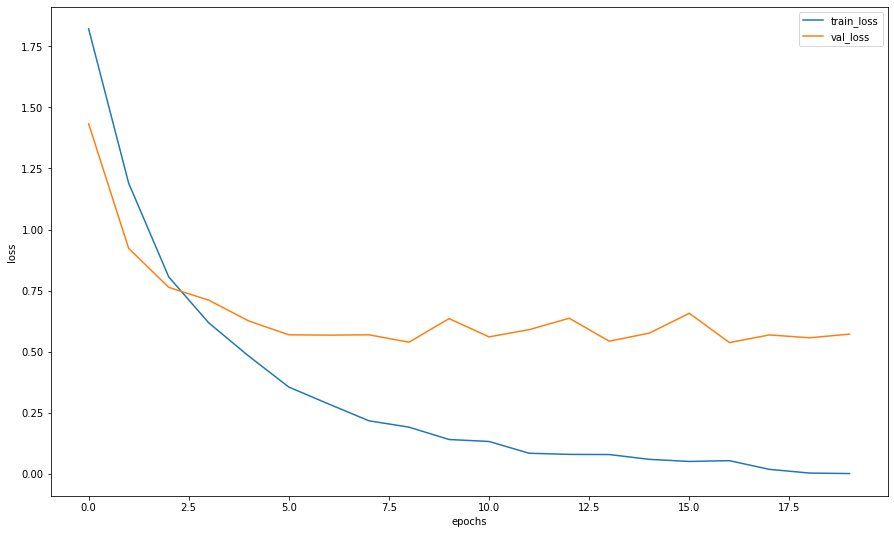

In [25]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

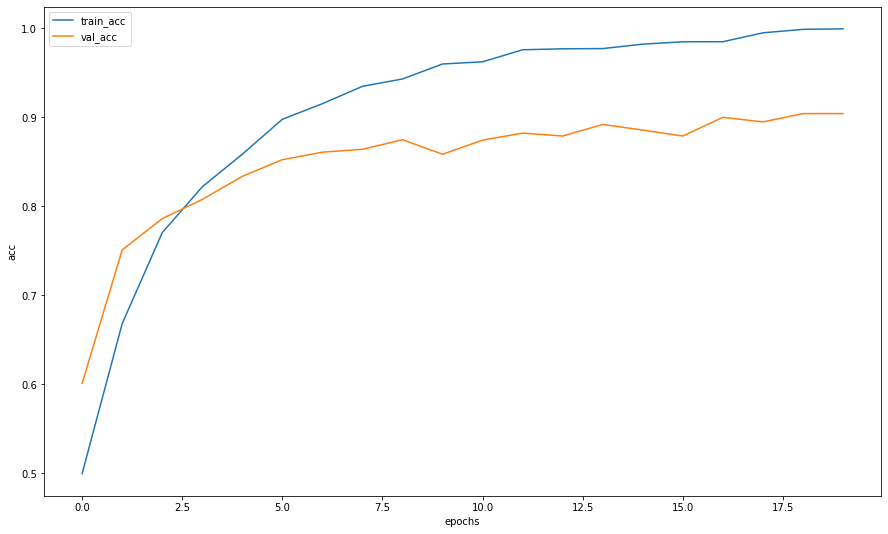

In [26]:
plt.figure(figsize=(15, 9))
plt.plot(acc, label="train_acc")
plt.plot(val_acc, label="val_acc")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("acc")
plt.show()

### Ну и что теперь со всем этим делать?

![alt text](https://www.indiewire.com/wp-content/uploads/2014/08/the-simpsons.jpg)

Хорошо бы понять, как сделать сабмит. 
У нас есть сеть и методы eval у нее, которые позволяют перевести сеть в режим предсказания. Стоит понимать, что у нашей модели на последнем слое стоит softmax, которые позволяет получить вектор вероятностей  того, что объект относится к тому или иному классу. Давайте воспользуемся этим.

In [0]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [28]:
random_characters = int(np.random.uniform(0,1000))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(model_cnn, ex_img.unsqueeze(0))

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2973: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


In [29]:
idxs = list(map(int, np.random.uniform(0,1000, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(model_cnn, imgs)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2973: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


In [0]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [0]:
y_pred = np.argmax(probs_ims,-1)

actual_labels = [val_dataset[id][1] for id in idxs]

preds_class = [label_encoder.classes_[i] for i in y_pred]

Обратите внимание, что метрика, которую необходимо оптимизировать в конкурсе --- f1-score. Вычислим целевую метрику на валидационной выборке.

In [45]:
from sklearn.metrics import f1_score

f1_score(actual_labels,np.argmax(probs_ims, axis=1), average = 'weighted')


0.8216666666666667

Сделаем классную визуализацию,  чтобы посмотреть насколько сеть уверена в своих ответах. Можете исспользовать это, чтобы отлаживать правильность вывода.

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2973: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


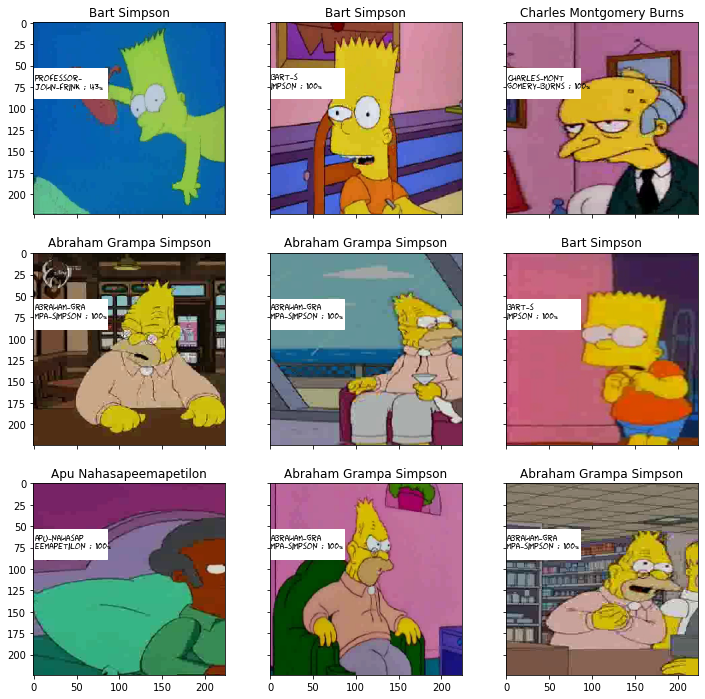

In [32]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    
    

    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)
    
    actual_text = "Actual : {}".format(img_label)
            
    fig_x.add_patch(patches.Rectangle((0, 53),86,35,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(model_cnn, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)
    
    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)
            
    fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')

Попробуйте найти те классы, которые сеть не смогла расспознать. Изучите данную проблему, это понадобится в дальнейшем.

### Submit на Kaggle

![alt text](https://i.redd.it/nuaphfioz0211.jpg)

In [33]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(model_cnn, test_loader)

preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2973: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


In [0]:
# ДОБАВЛЕНО: создание сабмита
import pandas as pd
df = pd.DataFrame()
df['Id'] = test_filenames
df['Expected'] = preds
df.to_csv('gdrive/My Drive/copy_simpsons.csv', index=False)
# файл появится у вас на гугл диске

In [35]:
! ls 

characters_illustration.png  label_encoder.pkl	sample_submission.csv  train
gdrive			     sample_data	testset


## Приключение?

А теперь самое интересное, мы сделали простенькую сверточную сеть и смогли отправить сабмит, но получившийся скор нас явно не устраивает. Надо с этим что-то сделать. 

Несколько срочныйх улучшейни для нашей сети, которые наверняка пришли Вам в голову: 


*   Учим дольше и изменяем гиперпараметры сети
*  learning rate, batch size, нормализация картинки и вот это всё
*   Кто же так строит нейронные сети? А где пулинги и батч нормы? Надо добавлять
*  Ну разве Адам наше все? [adamW](https://www.fast.ai/2018/07/02/adam-weight-decay/) для практика, [статейка для любителей](https://openreview.net/pdf?id=ryQu7f-RZ) (очень хороший анализ), [наши ](https://github.com/MichaelKonobeev/adashift/) эксперименты для заинтересованных.

* Ну разве это deep learning? Вот ResNet и Inception, которые можно зафайнтьюнить под наши данные, вот это я понимаю (можно и обучить в колабе, а можно и [готовые](https://github.com/Cadene/pretrained-models.pytorch) скачать).

* Данных не очень много, можно их аугументировать и  доучититься на новом датасете ( который уже будет состоять из, как  пример аугументации, перевернутых изображений)

* Стоит подумать об ансамблях


Надеюсь, что у Вас получится!

![alt text](https://pbs.twimg.com/profile_images/798904974986113024/adcQiVdV.jpg)
